In [446]:
import pandas
from sklearn import preprocessing
import numpy as np
import matplotlib.pyplot as plt

import warnings, os, tensorflow as tf

#env parameters
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
tf.logging.set_verbosity(tf.logging.ERROR)

In [447]:
num_segments = 19
test_split = 0.3

In [448]:
data = pandas.read_csv('/home/carsten/workspaces/isws/models/predictions_cnn.csv')
num_test_songs = int(len(data)*test_split)

In [449]:
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()

In [450]:
data = data.drop(['offset', 'duration', 'tempo', 'rms', 'mfcc18', 'mfcc19', 'mfcc20'],axis=1)
data.head()

,filename,chroma_stft,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc{i},mfcc{i}.1,mfcc{i}.2,mfcc{i}.3,...,blues,classical,country,disco,hiphop,jazz,metal,pop,reggae,rock
0,reggae.00009.wav,0.421017,1679.434736,2024.534270,3466.256905,0.064117,-262.811999,126.180913,11.227370,21.112270,...,0.002104,6.859838e-08,0.000811,0.000497,0.006404,0.000998,0.000067,0.001296,0.987532,0.000292
1,reggae.00009.wav,0.398483,1875.148780,2227.413557,4031.587601,0.069351,-220.923940,117.441621,4.900961,20.067881,...,0.006662,7.581472e-07,0.001360,0.000062,0.003177,0.008036,0.000010,0.000656,0.979826,0.000210
2,reggae.00009.wav,0.339041,1833.160181,2189.649126,3916.098976,0.067055,-206.509028,117.687803,3.399634,28.708057,...,0.026803,2.678702e-07,0.009727,0.001168,0.007188,0.001780,0.000055,0.003214,0.948763,0.001301
3,reggae.00009.wav,0.344620,1592.273248,2028.807317,3360.189056,0.054104,-232.590603,127.788885,7.052849,31.868343,...,0.066673,3.288872e-07,0.010435,0.000267,0.001951,0.006205,0.000016,0.002787,0.910743,0.000924
4,reggae.00009.wav,0.378558,1501.627471,1940.269736,3026.676750,0.051956,-243.499728,132.915085,4.320031,20.461475,...,0.006892,7.310875e-09,0.001107,0.000542,0.004395,0.000417,0.000006,0.001972,0.984400,0.000269


In [451]:
for i in range(len(data.filename)):
    res = data.iat[i,0]
    res = res.split('.')[0]
    data.iat[i,0] = res

In [452]:
genre_list = data.iloc[:, 0]
encoder = preprocessing.LabelEncoder()
y = encoder.fit_transform(genre_list)

In [453]:
scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(np.array(data.iloc[:, 1:], dtype = float))

In [454]:
X_test = X[:num_test_songs]
X_train = X[num_test_songs:]
y_test = y[:num_test_songs]
y_train = y[num_test_songs:]

In [455]:
from keras import models
from keras import layers

from keras.callbacks import EarlyStopping, ModelCheckpoint

In [456]:
val_split = int(19000*0.2)
x_val = X_train[:val_split]
partial_x_train = X_train[val_split:]

y_val = y_train[:val_split]
partial_y_train = y_train[val_split:]
x_norm = preprocessing.scale(x_val)

In [457]:
model = models.Sequential()
model.add(layers.Dense(35, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dense(20, activation='relu'))
model.add(layers.Dense(15, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

callbacks = [EarlyStopping(monitor='val_loss', patience=10),
                 ModelCheckpoint(filepath='./../../../models/ann-model-best.h5', monitor='val_loss', save_best_only=True)]

history = model.fit(partial_x_train,
          partial_y_train,
          epochs=200,
          batch_size=512,
          callbacks=callbacks,
          validation_data=(x_val, y_val))
results = model.evaluate(X_test, y_test)

Train on 9500 samples, validate on 3800 samples
Epoch 1/200
9500/9500 [==============================] - 1s 149us/step - loss: 2.1903 - acc: 0.1500 - val_loss: 2.0308 - val_acc: 0.2647
Epoch 2/200
9500/9500 [==============================] - 0s 11us/step - loss: 1.8859 - acc: 0.3358 - val_loss: 1.7438 - val_acc: 0.3861
Epoch 3/200
9500/9500 [==============================] - 0s 10us/step - loss: 1.5639 - acc: 0.5113 - val_loss: 1.4319 - val_acc: 0.5539
Epoch 4/200
9500/9500 [==============================] - 0s 10us/step - loss: 1.2303 - acc: 0.6894 - val_loss: 1.1393 - val_acc: 0.6829
Epoch 5/200
9500/9500 [==============================] - 0s 10us/step - loss: 0.9369 - acc: 0.7705 - val_loss: 0.8919 - val_acc: 0.7647
Epoch 6/200
9500/9500 [==============================] - 0s 11us/step - loss: 0.7065 - acc: 0.8333 - val_loss: 0.7048 - val_acc: 0.8205
Epoch 7/200
9500/9500 [==============================] - 0s 10us/step - loss: 0.5524 - acc: 0.8625 - val_loss: 0.5935 - val_acc: 0.8429

In [458]:
print("Results: " + str(results))

Results: [1.3550253267259451, 0.6591228070175439]


In [459]:
p = model.predict(X_test)

In [460]:
from sklearn.metrics import confusion_matrix
print(p.argmax(axis=1))
r = []
for int_res in p.argmax(axis=1):
    r.append(genres[int_res])
cm = confusion_matrix(encoder.inverse_transform(y_test), r, genres)

cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm = np.around(cm, decimals=2)

[8 8 8 ... 5 5 5]


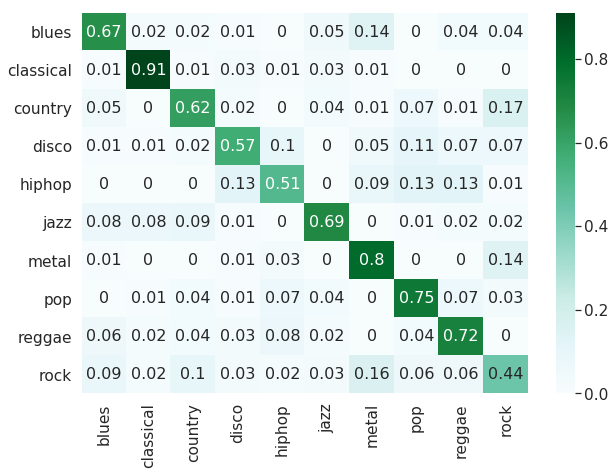

In [461]:
import pandas as pd, seaborn as sn, matplotlib.pyplot as plt
df_cm = pd.DataFrame(cm, genres,
                  genres)
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size

ax=sn.heatmap(df_cm, annot=True,annot_kws={"size": 16}, cmap="BuGn")# font size

In [462]:
def show_summary_stats(history):
    # List all data in history
    print(history.history.keys())

    # Summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


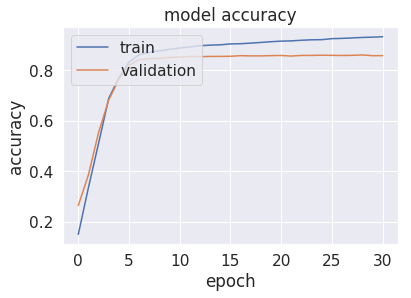

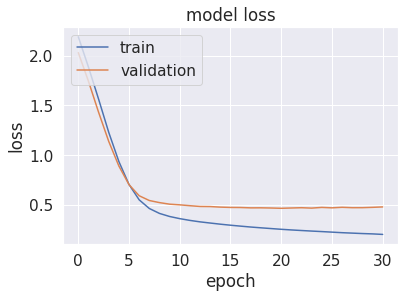

In [463]:
show_summary_stats(history)

In [464]:
def evaluate_songs(songdata=X_test, true_vals=y_test, model=model):
    pred_genres = []
    prediction = []
    true_genres = []
    predictions = model.predict(songdata)
    for i in range(len(predictions)):
        if i%19 == 0:
            true_genres.append(true_vals[i])
            pred_genres.append(prediction)
            prediction = predictions[i]        
        else:
            prediction = (prediction + predictions[i])/2
    pred_genres.append(prediction)
    np.delete(pred_genres, [0])
    return pred_genres, true_genres

In [465]:
len(X_test)
pred_genres, true_genres = evaluate_songs()
print(len(true_genres))
c = 0
for i in range(len(pred_genres)):
    if i != 0:
        if pred_genres[i].argmax(axis=0) == true_genres[i-1]:
            c = c + 1
print(c)
acc = c/len(true_genres)*100
print("Accuracy: " + str(acc) + "%")

300
211
Accuracy: 70.33333333333334%
